In [36]:
import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.colors
import numpy as np

import xarray as xr
import xroms
import matplotlib.pyplot as plt
from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf
#from roguewave.wavespectra.estimators.estimate import estimate_directional_distribution
#%run -i roguewave_estimators.py
%run -i wave_stats.py

In [ ]:
roms_file = 'http://icoast.rc.ufl.edu/thredds/dodsC/ian/L1_BEST_AVAILABLE/ocean_his.nc'
run_name = 'L1_20230123'

ds_mod = xroms.open_netcdf(roms_file)
time_ini_model = ds_mod.ocean_time.values[0]
time_end_model = ds_mod.ocean_time.values[-1]

In [2]:
# These are the GOM buoys with data for Ian
buoys = ['42039','42098', '42099']
# pick one for testing
buoy = buoys[0]

In [3]:
MODEL_DIRECTORY = '/vortexfs1/share/usgs-share/Projects/Ian2022/ian10/drifters/'

In [4]:
# Process one buoy as a test
fn = "{}.spc2d".format(buoy)
dsm = read_swan(MODEL_DIRECTORY+fn)
# get start/end times
stime = dsm.time[0].values
etime = dsm.time[-1].values
print(stime,' to ',etime)
dtmod = np.squeeze( dsm.time.values )
hsmod = np.squeeze( dsm.efth.spec.hs().values )

2022-09-26T00:00:00.000000000  to  2022-10-02T00:00:00.000000000


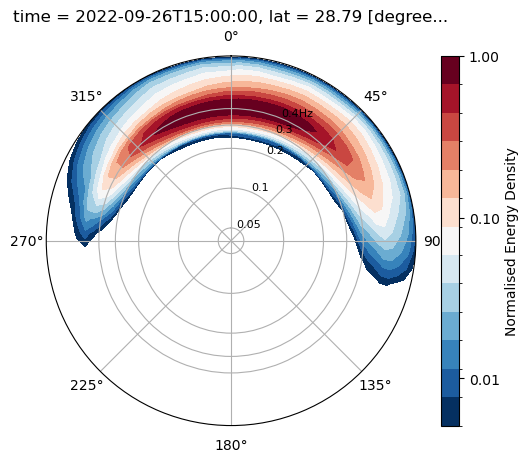

In [15]:
dst = dsm.isel(lat=0,lon=0,time=15)
dst.spec.plot()

In [18]:
# assume the file has all years, thus w9999 instead of w2022
# read the NDBC buoy observations for the same time slice
url ='https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/' + str(buoy) + '/' + str(buoy) + 'w9999' + '.nc'
print(url)
dso = read_ndbc(url, dd=10.0, chunks={}).sel(time=slice(stime, etime))
dtobs = np.squeeze(dso.time)
hsobs = np.squeeze(dso.efth.spec.hs().values)
dmobs = np.squeeze(dso.efth.spec.dm().values)
dsprobs = np.squeeze(dso.efth.spec.dspr().values)
sweobs = np.squeeze(dso.efth.spec.swe().values)
swobs = np.squeeze(dso.efth.spec.sw().values)
print('dmobs:', dmobs[80])
print('dspr:', dsprobs[80])

# interpolate modeled to times of observation (in case some are missing)
dsmi = dsm.interp(time=dso.time, method='nearest')
hsmodi = np.squeeze( dsmi.efth.spec.hs().values )
rmse = np.sqrt( np.nanmean( (hsobs - hsmodi)**2) )
print(rmse)

https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42039/42039w9999.nc


/vortexfs1/home/csherwood/mambaforge/envs/NOPP/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


dmobs: nan
dspr: nan
0.2072119026495582


/vortexfs1/home/csherwood/mambaforge/envs/NOPP/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


12.0
nan


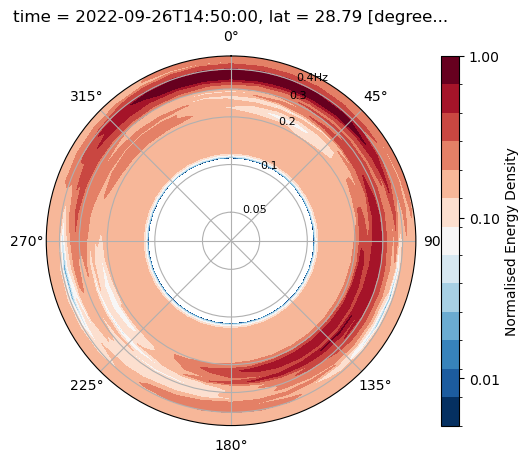

In [25]:
dsij=dso.isel(time=14,lat=0,lon=0)
print(dsij.spec.dpm().values)
print(dsij.spec.dspr().values)
dsij.spec.plot()

In [27]:
url ='https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/' + str(buoy) + '/' + str(buoy) + 'w9999' + '.nc'
ds = xr.open_dataset(url)
time_ini_model = datetime.strptime('2022-09-26', '%Y-%m-%d')
time_end_model = datetime.strptime('2022-10-01', '%Y-%m-%d')
ds = ds.sel(time=slice(time_ini_model,time_end_model))
ds

<xarray.Dataset>
Dimensions:                (time: 118, frequency: 46, latitude: 1, longitude: 1)
Coordinates:
  * time                   (time) datetime64[ns] 2022-09-26T00:50:00 ... 2022...
  * frequency              (frequency) float32 0.033 0.038 0.043 ... 0.465 0.485
  * latitude               (latitude) float32 28.79
  * longitude              (longitude) float32 -86.01
Data variables:
    spectral_wave_density  (time, frequency, latitude, longitude) float32 ...
    mean_wave_dir          (time, frequency, latitude, longitude) float64 ...
    principal_wave_dir     (time, frequency, latitude, longitude) float64 ...
    wave_spectrum_r1       (time, frequency, latitude, longitude) float32 ...
    wave_spectrum_r2       (time, frequency, latitude, longitude) float32 ...
Attributes:
    institution:                     NOAA National Data Buoy Center and Parti...
    url:                             http://dods.ndbc.noaa.gov
    quality:                         Automated QC checks with daily manual QC
    conventions:                     COARDS
    station:                         42039
    comment:                         PENSACOLA - 115NM SSE of Pensacola, FL
    location:                        28.788 N 86.008 W 
    DODS_EXTRA.Unlimited_Dimension:  time

In [35]:
f = np.squeeze( ds.frequency )
for i in np.arange(len(ds['time'])):
    a1, b1, a2, b2 = to_moment( ds.wave_spectrum_r1[i], ds.wave_spectrum_r1[i], ds.mean_wave_dir[i], ds.principal_wave_dir[i] )
    spec1d = np.squeeze( ds.spectral_wave_density[i] )
    thetamw = calc_weighted_theta_mean_a1b1( a1, b1, spec1d, f )
    sigmatheta = calc_sigma_theta_a1b1( a1, b1, spec1d, f )
    print(thetamw, sigmatheta)

coeff: -4.221967654925768
83.10877505399026 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.0359649172015155
87.27106143186796 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.072738237199316
92.84109046104916 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.046901497609779
94.77019871992005 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.9643762744677487
99.24755432475291 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.074157152932492
99.84434251563778 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.050591731594457
105.27982701037243 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.179037939883383
112.29885086332493 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.160742735916384
109.1009105884664 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.13723562676031
116.68823874833203 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.9896507711410054
113.81528328154803 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.1586676935758904
110.4293295311123 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.2042409511163936
98.56111300702918 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -1.714583085791181
66.54904772613082 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -1.926483819191577
39.23922089528378 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.428846531735599
9.81595710479769 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -1.9819156510797673
22.97172136787981 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -1.8887684085416647
15.030298702227583 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.0670878158110813
358.7305956891511 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.221711427954727
346.4252678135414 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.922224414557131
341.9981081650112 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.1338596128302516
330.30107225549904 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.870808289034843
331.1688809130265 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.969942602308853
329.91862790926785 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.847930120611262
339.5095318267383 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.581657283090776
337.3969129496769 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -2.086327630190697
349.03427930409373 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -1.4722173013381115
357.17633446985815 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -1.7035096697630987
7.875696942077127 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -1.8452689302732272
342.6673694448698 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.0389188377705194
348.02480817145283 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.8312907846627136
0.032518659558718355 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.332163602558632
2.8385757439510826 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.5060304899801125
5.5396348485619455 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.5270159849723095
12.330130866979061 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.486024048931792
18.20301274771373 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.366383870058668
21.746748784741726 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.296465887275873
26.483635086394827 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.088491506176964
25.052121688277282 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.8768848072246396
30.674796162530583 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.6763595818897743
32.87070467366482 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.911469447780668
37.44200427505268 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.614952692436864
39.50533115767706 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.697891256823226
40.73446377562681 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.4767564362735843
39.83609063538677 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.634013389124771
35.755883441373385 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.6686339793094014
36.21134371688373 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.763768441369912
31.061773157693608 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.878558401071791
40.4656619338885 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.9485375859776912
36.95080341852264 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.131863131396845
42.269860063509896 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.03571788991161
44.507519416881735 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.241323818692804
49.58559519235706 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.083975492271981
53.7625028841569 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.9819569192324407
50.50909542902298 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.017001609953761
43.162870078498486 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.89806591326301
41.84085739902304 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.110321671420009
29.019132239762143 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.63470532238819
41.43585032876581 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.736254966126679
38.72476635463647 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.876163524027268
39.71775766092361 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.038582757319798
42.283744682214945 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.952130980292506
35.973845478110206 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.276048032254996
45.0531227611213 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.162316279375134
39.09439107346657 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.5233160446313
46.17171336107185 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.144749389250654
44.59723957051392 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.6194821801884407
40.508321288185925 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.5240237433892867
33.406482883223134 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.9609957485385445
37.096962323211415 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.901274387330365
29.176140435726097 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.8184071807324464
27.165736115995742 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.016454641380508
26.477453298094304 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.957814149627999
27.04595033045075 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.069676993606526
30.926801591222045 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.1854653602137
20.106887191092596 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.452522970285575
21.200642279809244 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.450031809749956
17.039207064474056 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.097160234405397
21.708371185699207 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.143784729248381
21.82993603293039 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.459085810708862
23.54475506376565 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.410569330078455
28.25953315141544 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.262885075659375
28.70937904521992 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.283296110909444
27.039852628243693 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.169776544260986
25.762695494123932 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.249039880999479
30.779369480804803 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.0599477504492985
24.463026678669507 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.713659731684242
25.99423925363203 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.691323915079887
25.607662838025476 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.7140319777689097
27.92536572730836 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.43897880149832
28.83818944682929 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.3846669881667664
19.62226916152241 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.7364978627791876
16.12792662849165 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.7647534891552192
12.645062243902373 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.043823080842488
10.967552673884597 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.183724745653001
16.112191567909917 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.441640581316711
13.727488787295954 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.370408697321503
15.995666450404315 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.353301912696994
17.67567828418038 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.256743393765416
25.999009537354766 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.160260567553566
24.00361791265692 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.22502206695508
26.7328643701386 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.237300584287135
24.60959738023496 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.121407240354435
31.069812404716743 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -4.080455880372061
35.21297886894564 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.934051547589201
35.701086039036966 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.8684673954234663
38.53220908214769 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.5868801530183854
47.681465234614905 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.7539065315663525
52.72397555138184 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.697127587592263
44.8269522651417 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.4834551465364134
49.68705060294053 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.43511747730441
44.76862661055077 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.6246304139776395
40.24473498434992 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.3584835173236405
30.91457819049208 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.1206551996152267
18.615259137904275 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.3394228934321752
18.979288271569033 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.4446336482473052
7.729166238008759 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


coeff: -3.7489456207308836
358.22912632379524 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


In [28]:
#for i in np.arange(len(ds.time)):
i=18

a1, b1, a2, b2 = to_moment( ds.wave_spectrum_r1[i], ds.wave_spectrum_r1[i], ds.mean_wave_dir[i], ds.principal_wave_dir[i] )
spec1d = np.squeeze( ds.spectral_wave_density[i] )
thetamw = calc_weighted_theta_mean_a1b1( a1, b1, spec1d, f )
sigmatheta = calc_sigma_theta_a1b1( a1, b1, spec1d, f )
print(thetamw, sigmatheta)

coeff: -2.0670878158110813
358.7305956891511 nan


/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:160: RuntimeWarning: invalid value encountered in sqrt
  s1 = (180./np.pi) * np.sqrt( 2. * ( 1. - np.sqrt( a1bar**2 + b1bar**2 ) ) )


In [ ]:
plt.plot(f,np.squeeze(spec1d))
plt.plot(f,np.squeeze(a1))
plt.plot(f,np.squeeze(b1))

In [ ]:
time_ini_model = datetime.strptime('2022-09-26', '%Y-%m-%d')
time_end_model = datetime.strptime('2022-10-01', '%Y-%m-%d')
buoys = "42097","42099","42098"

for buoy in buoys:
     # Open dataset
     url ='https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/' + str(buoy) + '/' + str(buoy) + 'h9999.nc'
     ds = xr.open_dataset(url)
     lat1 = ds.latitude.values
     lon1 = ds.longitude.values
     print(lon1,lat1)
     ds = ds.sel(time=slice(time_ini_model,time_end_model)) ####<<<<<We can us the datetime object to subset. no need to convert to strings. 

     #HWavel = ds_mod.Hwave.xroms.sel2d(lon1, lat1)

     plt.figure()
     ds.wave_height.plot()
     #HWavel.plot()
     plt.title('NDBC buoy observations')
     plt.ylabel('Significat Wave height, m')
     plt.xlabel('YYYY-MM-DD, UTC')
     #plt.gca().legend([buoy, "L1 COAWST"])
     fig_name = buoy + '_v2_' + run_name + '.png'
     #plt.savefig(fig_name)

In [ ]:
ds